In [1]:
# import packages
%pylab inline

import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.util import add_cyclic_point
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import colorbar, colors
from scipy.stats import poisson
import numpy as np
import random
import regionmask
from scipy.stats import linregress


import sys
wython = '/tigress/wenchang/wython'
if wython not in sys.path: sys.path.append(wython)
from xtc import wherebasin
from geoplots import mapplot

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
There are some problems for the deprecated basemap package.


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

### Function to calculate distances

In [3]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # compute distance between 2 points
    
    R = 6371  # Earth radius in kilometers

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Example
distance_km = haversine(45, 320, 45, 317)
print(distance_km)

235.8665859053396


### IBTrACS Data

In [4]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/stitch_data_output'

# ----- IBTrACS data ---------

dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/AI_model_test'
ibtracs = xr.open_dataset("{}/IBTrACS.NA.v04r01.nc".format(dloc)).load()

# extract 2005 season
ibtracs_atl = ibtracs.where(
    (ibtracs.time >= np.datetime64('2018-01-01')) & 
    (ibtracs.time <= np.datetime64('2024-12-31')),
    drop=True
)

# ensure longitude coordinates align with the ERA5 data
ibtracs_atl['lon'] = ibtracs_atl['lon'] % 360
ibtracs_atl['lon'] = ibtracs_atl['lon'].where(ibtracs_atl['lon']>190, other=ibtracs_atl['lon']+360)
#ibtracs_2005 = ibtracs_2005.sortby('lon')  # Optional

# unit conversion for consistency with model
ibtracs_atl['wmo_wind'] = ibtracs_atl['wmo_wind'] * 0.514444         # windspeed from kt to m/s
ibtracs_atl['storm_speed'] = ibtracs_atl['storm_speed'] * 0.514444   # translation speed from kt to m/s
ibtracs_atl['wmo_pres'] = ibtracs_atl['wmo_pres'] * 100              # min slp from hPa to Pa

### Plot the storms and define the box for downstream effects

In [5]:
ibtracs_atl['lon'] = (((ibtracs_atl.lon + 180) % 360) - 180)

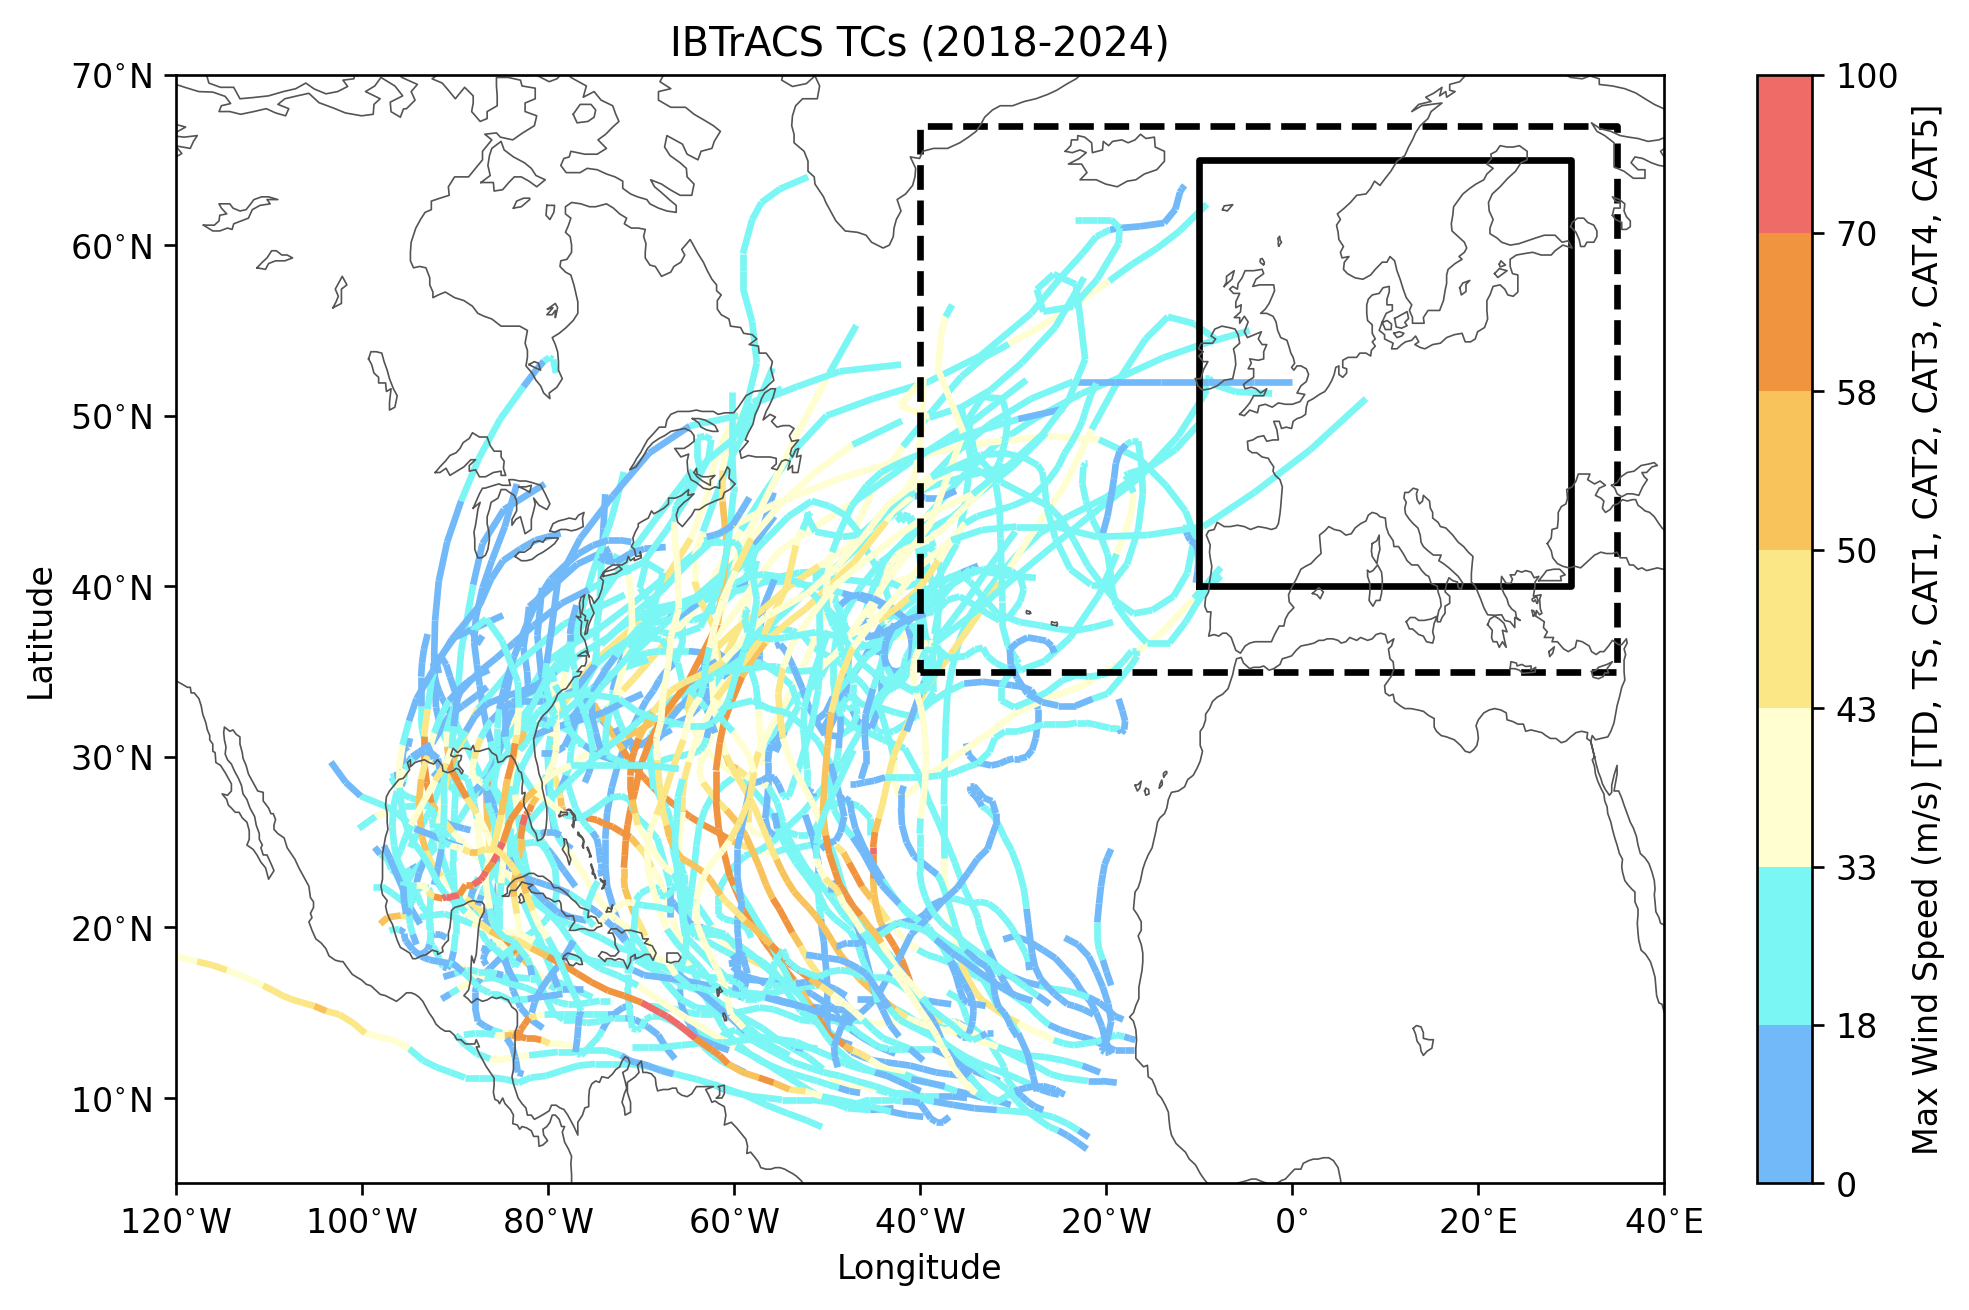

In [125]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
import numpy as np

# Define colormap and levels
cmap = ListedColormap(np.array([
    (114, 185, 249),
    (122, 246, 244),
    (255, 254, 209),
    (252, 231, 134),
    (247, 195, 90),
    (241, 148, 64),
    (238, 107, 103)
]) / 255.0)

levels = [0, 18, 33, 43, 50, 58, 70, 100]
norm = BoundaryNorm(levels, ncolors=cmap.N)

fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each storm
for i in range(ibtracs_atl.sizes['storm']):
    lat = ibtracs_atl.lat.isel(storm=i).values
    lon = ibtracs_atl.lon.isel(storm=i).values
    wind = ibtracs_atl.wmo_wind.isel(storm=i).values

    # Mask invalid (nan) values
    mask = ~np.isnan(lat) & ~np.isnan(lon) & ~np.isnan(wind)
    lat = lat[mask]
    lon = lon[mask]
    wind = wind[mask]

    if len(lat) < 2:
        continue  # Not enough points to form a track

    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(wind[:-1])
    lc.set_linewidth(2)
    ax.add_collection(lc)

# Set axis limits based on data
ax.set_xlim(-120, 40) 
ax.set_ylim(5, 70) 
#ax.set_xlim(np.nanmin(ibtracs_atl.lon), np.nanmax(ibtracs_atl.lon))
#ax.set_ylim(np.nanmin(ibtracs_atl.lat), np.nanmax(ibtracs_atl.lat))

# Add colorbar
cbar = plt.colorbar(lc, ax=ax, boundaries=levels, ticks=levels)
cbar.set_label("Max Wind Speed (m/s) [TD, TS, CAT1, CAT2, CAT3, CAT4, CAT5]")

# box for europe
europe_lon = [-10, 30, 30, -10, -10]
europe_lat = [40, 40, 65, 65, 40]
ax.plot(europe_lon, europe_lat, color='black', linestyle='-', linewidth=2, label='Europe Box')

# box for tc threshold
tc_lon = [-40, 35, 35, -40, -40]
tc_lat = [35, 35, 67, 67, 35]
ax.plot(tc_lon, tc_lat, color='black', linestyle='--', linewidth=2, label='TC Box')


# Optional: add coastlines or map if using mapplot()
mapplot()


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("IBTrACS TCs (2018-2024)")
plt.show()


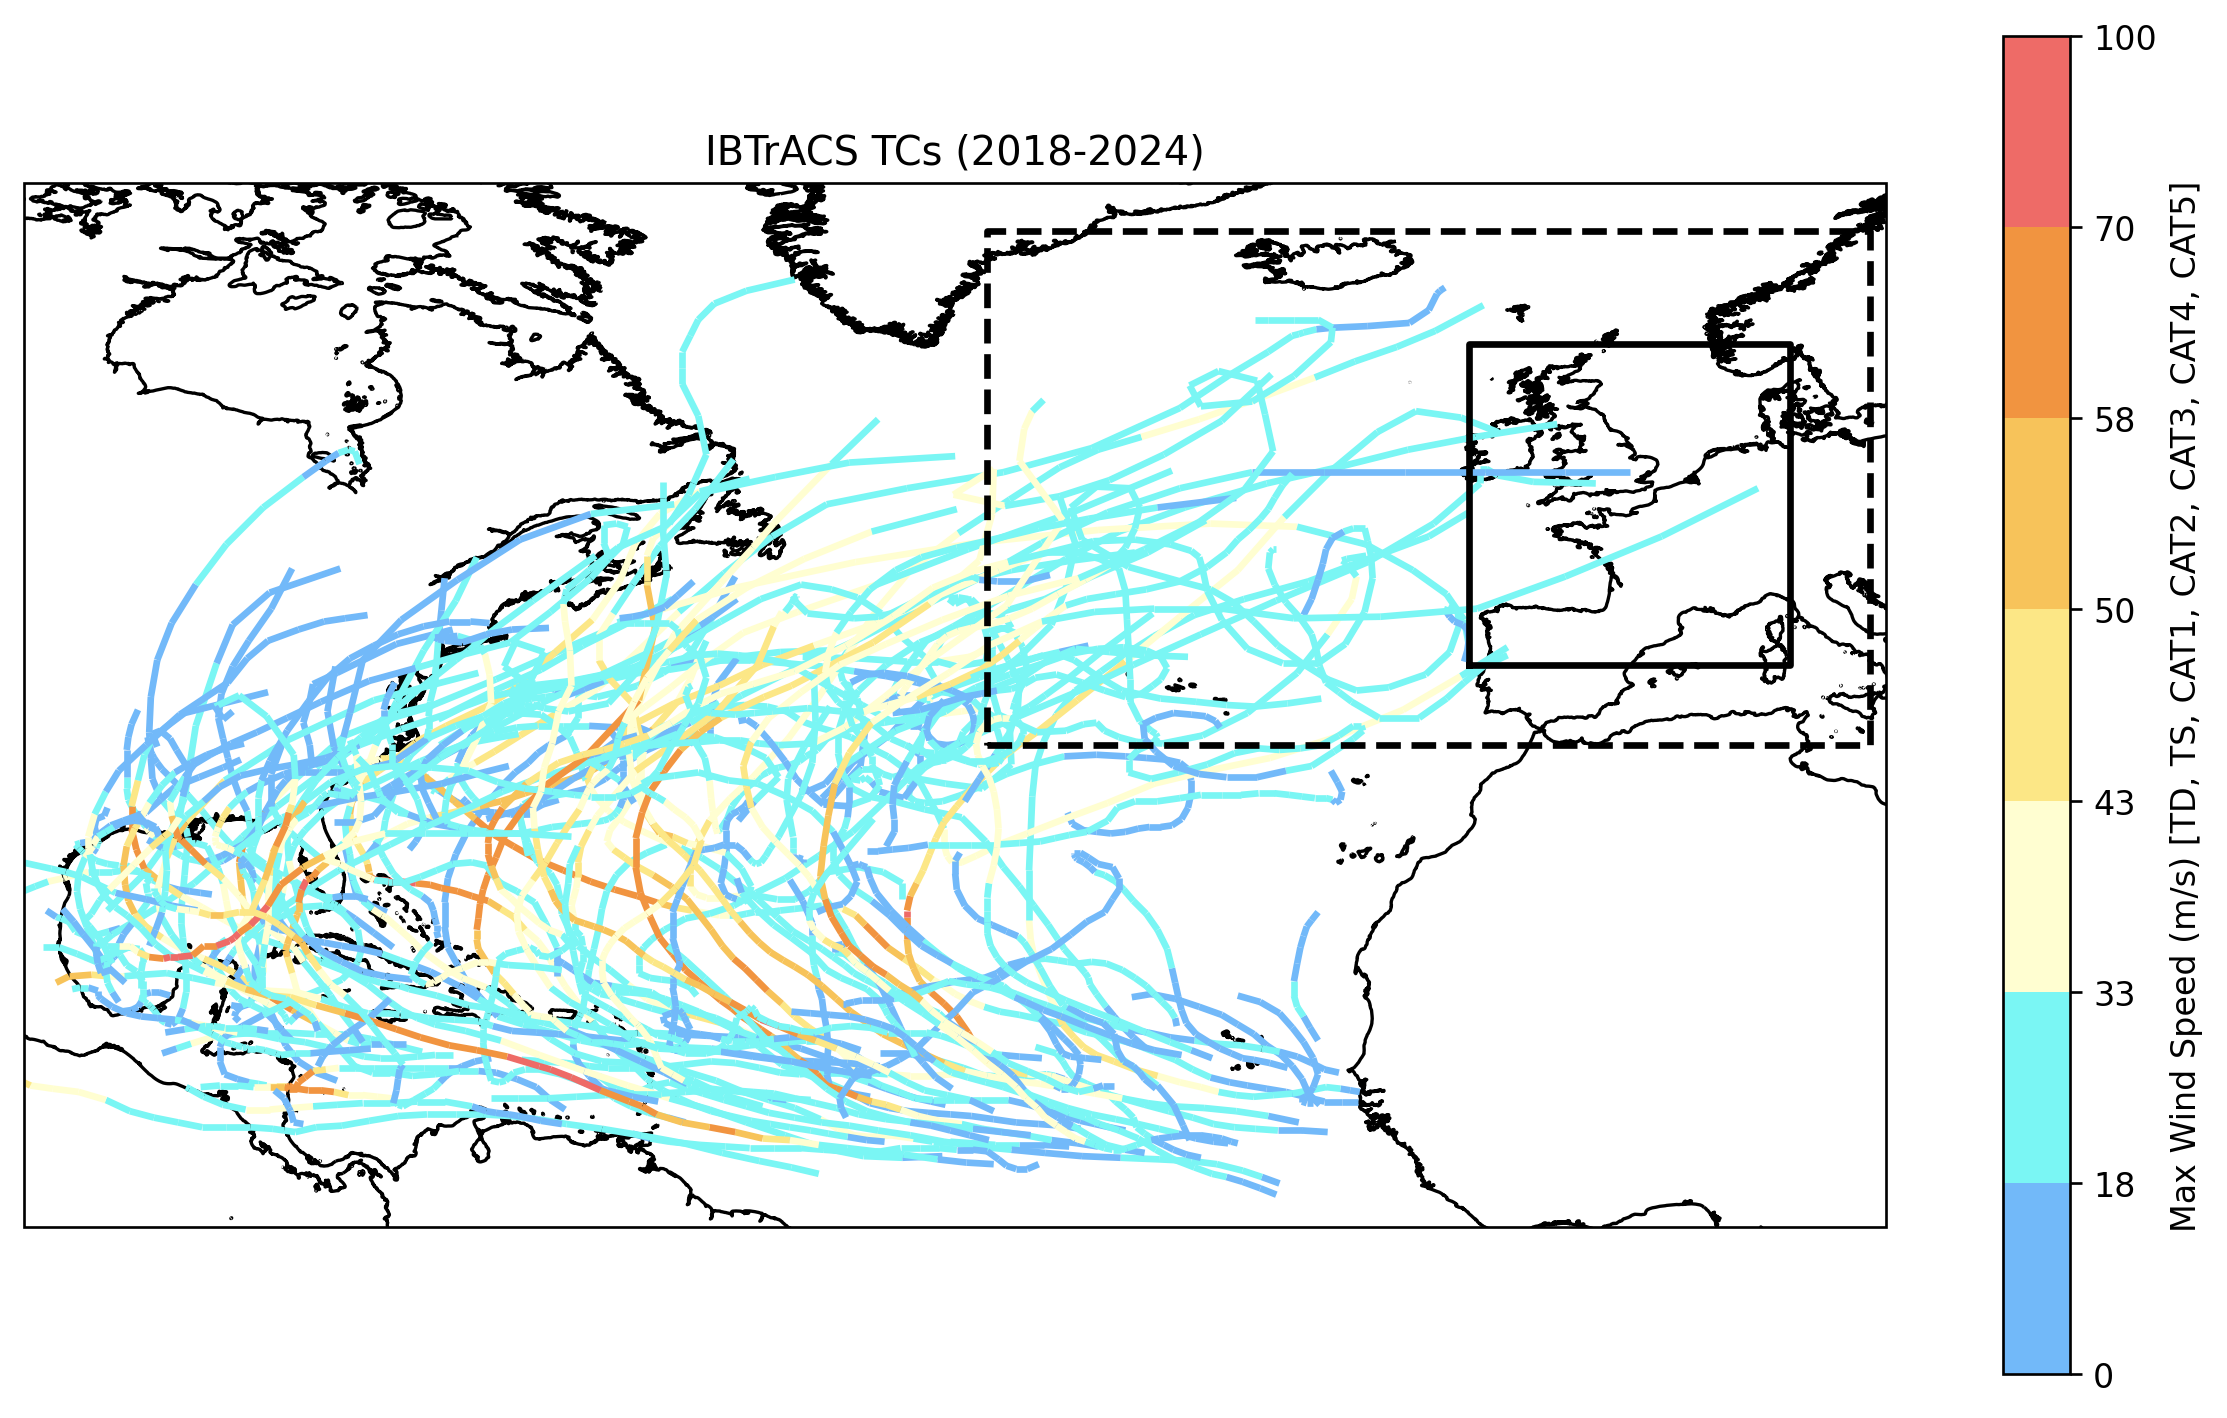

In [186]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
import numpy as np

# Define colormap and levels
cmap = ListedColormap(np.array([
    (114, 185, 249),
    (122, 246, 244),
    (255, 254, 209),
    (252, 231, 134),
    (247, 195, 90),
    (241, 148, 64),
    (238, 107, 103)
]) / 255.0)

levels = [0, 18, 33, 43, 50, 58, 70, 100]
norm = BoundaryNorm(levels, ncolors=cmap.N)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Loop over each storm
for i in range(ibtracs_atl.sizes['storm']):
    lat = ibtracs_atl.lat.isel(storm=i).values
    lon = ibtracs_atl.lon.isel(storm=i).values
    wind = ibtracs_atl.wmo_wind.isel(storm=i).values

    # Mask invalid (nan) values
    mask = ~np.isnan(lat) & ~np.isnan(lon) & ~np.isnan(wind)
    lat = lat[mask]
    lon = lon[mask]
    wind = wind[mask]

    if len(lat) < 2:
        continue  # Not enough points to form a track

    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(wind[:-1])
    lc.set_linewidth(2)
    ax.add_collection(lc)

# Set axis limits based on data
ax.set_xlim(-120, 40) 
ax.set_ylim(5, 70) 
#ax.set_xlim(np.nanmin(ibtracs_atl.lon), np.nanmax(ibtracs_atl.lon))
#ax.set_ylim(np.nanmin(ibtracs_atl.lat), np.nanmax(ibtracs_atl.lat))

# Add colorbar
cbar = plt.colorbar(lc, ax=ax, boundaries=levels, ticks=levels)
cbar.set_label("Max Wind Speed (m/s) [TD, TS, CAT1, CAT2, CAT3, CAT4, CAT5]")

# box for europe
europe_lon = [-10, 10, 10, -10, -10]
europe_lat = [40, 40, 60, 60, 40]
#ax.plot(europe_lon, europe_lat, color='black', linestyle='-', linewidth=2, label='Europe Box')

# box for tc threshold
tc_lon = [-40, 15, 15, -40, -40]
tc_lat = [35, 35, 67, 67, 35]
#ax.plot(tc_lon, tc_lat, color='black', linestyle='--', linewidth=2, label='TC Box')
ax.plot(europe_lon, europe_lat, transform=ccrs.PlateCarree(), color='black', linestyle='-', linewidth=2)
ax.plot(tc_lon, tc_lat, transform=ccrs.PlateCarree(), color='black', linestyle='--', linewidth=2)


# Add coastlines and features
ax.coastlines(resolution='10m')

# Set extent
ax.set_extent([-100, 16, 5, 70], crs=ccrs.PlateCarree())


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("IBTrACS TCs (2018-2024)")
plt.tight_layout()
plt.show()


In [168]:
# looping through each storm and determining the first day the storm falls in the dashed box

# define the box
lon_min, lon_max = -40, 35
lat_min, lat_max = 35, 67


first_entry_dates = []

for i in range(ibtracs_atl.sizes['storm']):
    lat = ibtracs_atl.lat.isel(storm=i).values
    lon = ibtracs_atl.lon.isel(storm=i).values
    time = ibtracs_atl.time.isel(storm=i).values

    # Mask valid values
    mask = ~np.isnan(lat) & ~np.isnan(lon)

    lat = lat[mask]
    lon = lon[mask]
    time = time[mask]

    # Check which points fall inside the box
    inside = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)

    if np.any(inside):
        first_time = time[np.argmax(inside)]  # first time True appears
        first_entry_dates.append(pd.to_datetime(first_time))



In [169]:
first_entry_dates

[Timestamp('2018-07-13 18:00:00.000039936'),
 Timestamp('2018-08-02 18:00:00.000039936'),
 Timestamp('2018-08-17 03:00:00.000039936'),
 Timestamp('2018-09-15 00:00:00.000039936'),
 Timestamp('2018-09-12 00:00:00.000039936'),
 Timestamp('2018-09-26 15:00:00.000039936'),
 Timestamp('2018-10-13 21:00:00.000039936'),
 Timestamp('2018-11-02 00:00:00.000039936'),
 Timestamp('2019-09-10 12:00:00.000039936'),
 Timestamp('2019-10-01 15:00:00.000039936'),
 Timestamp('2019-10-23 18:00:00.000039936'),
 Timestamp('2019-10-28 06:00:00.000039936'),
 Timestamp('2019-11-24 12:00:00.000039936'),
 Timestamp('2020-07-07 09:00:00.000039936'),
 Timestamp('2020-09-17 00:00:00.000039936'),
 Timestamp('2020-09-14 12:00:00.000039936'),
 Timestamp('2020-10-26 03:00:00.000039936'),
 Timestamp('2021-08-30 06:00:00.000039936'),
 Timestamp('2021-09-22 03:00:00.000039936'),
 Timestamp('2021-10-05 03:00:00.000039936'),
 Timestamp('2021-11-03 12:00:00.000039936'),
 Timestamp('2022-09-07 00:00:00.000039936'),
 Timestamp

In [170]:
len(first_entry_dates)

32

### Get daily ERA5 skin temperatures

In [171]:
dloc = '/projects/w/wenchang/data/era5/analysis_wy/skin_temperature/daily'

months = ['07', '08', '09', '10', '11']
years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024']

skt_list = []
lon_min, lon_max = -10, 10
lat_min, lat_max = 40, 60


for year in years:
    for month in months:
        # get data (hourly)
        file_path = f"{dloc}/era5.skin_temperature.daily.{year}-{month}.nc"
        try:
            # extract daya
            ds = xr.open_dataset(file_path)
            daily_skt = ds.skt.load()

            # only extract data in the european box
            daily_skt['longitude'] = (((daily_skt.longitude + 180) % 360) - 180)
            data_in_box = daily_skt.where(
                (daily_skt.longitude >= lon_min) & (daily_skt.longitude <= lon_max) &
                (daily_skt.latitude >= lat_min) & (daily_skt.latitude <= lat_max),
                drop=True
            )
            daily_avg = data_in_box.mean(dim=['latitude', 'longitude'])
            skt_list.append(daily_avg)
            print(year, month)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

# Concatenate along time (often called "time" or "valid_time")
skt_concat = xr.concat(skt_list, dim='time')

2018 07
2018 08
2018 09
2018 10
2018 11
2019 07
2019 08
2019 09
2019 10
2019 11
2020 07
2020 08
2020 09
2020 10
2020 11
2021 07
2021 08
2021 09
2021 10
2021 11
2022 07
2022 08
2022 09
2022 10
2022 11
2023 07
2023 08
2023 09
2023 10
2023 11
2024 07
2024 08
2024 09
2024 10
2024 11


### Look at the 10 days following a TC entering the box

I will loop through each of the 32 dates (of TCs entering the box). For each date. I will take that date and look at the 10 dates following it and compare to the monthly climatology. For example. If the first date in my list of 32 is June 28, 2018 I want to take the June 29th 2018 and compare it to the June climatology for the ERA5 dataset, June 30th 2018 and compare to the june climatology for the ERA5 dataset, July 1 2018 and compare it to the July climatology for the ERA5 dataset so on until we have 10 days after June 28. I will do this for each of the 32 dates. So for each of the 32 dates I have 10 numbers associated with how far above or below the climatology the temperature is following that date.

In [181]:

anomaly_matrix = []

days_after = 10

for base_date in first_entry_dates:
    anomalies = []

    for offset in range(1, days_after+1):
        target_date = pd.to_datetime(base_date) + pd.Timedelta(days=offset)
        
        try:
            skt_value = skt_concat.sel(time=target_date, method='nearest').item()
            

        except KeyError:
            anomalies.append(np.nan)
            continue

        mon = target_date.month

        # Check if month is present in climatology
        if mon in climatology['month']:
            clim_value = climatology.sel(month=mon).item()
        else:
            anomalies.append(np.nan)
            continue

        anomaly = skt_value - clim_value
        print(target_date, skt_value, clim_value, anomaly)
        anomalies.append(anomaly)


    anomaly_matrix.append(anomalies)


2018-07-14 18:00:00.000039936 293.033203125 291.79461669921875 1.23858642578125
2018-07-15 18:00:00.000039936 292.6009826660156 291.79461669921875 0.806365966796875
2018-07-16 18:00:00.000039936 292.6010437011719 291.79461669921875 0.806427001953125
2018-07-17 18:00:00.000039936 292.7783508300781 291.79461669921875 0.983734130859375
2018-07-18 18:00:00.000039936 293.0461730957031 291.79461669921875 1.251556396484375
2018-07-19 18:00:00.000039936 292.4192199707031 291.79461669921875 0.624603271484375
2018-07-20 18:00:00.000039936 292.1261901855469 291.79461669921875 0.331573486328125
2018-07-21 18:00:00.000039936 292.649658203125 291.79461669921875 0.85504150390625
2018-07-22 18:00:00.000039936 293.5050964355469 291.79461669921875 1.710479736328125
2018-07-23 18:00:00.000039936 293.8583984375 291.79461669921875 2.06378173828125
2018-08-03 18:00:00.000039936 294.7707214355469 291.89703369140625 2.873687744140625
2018-08-04 18:00:00.000039936 294.4109802246094 291.89703369140625 2.5139465

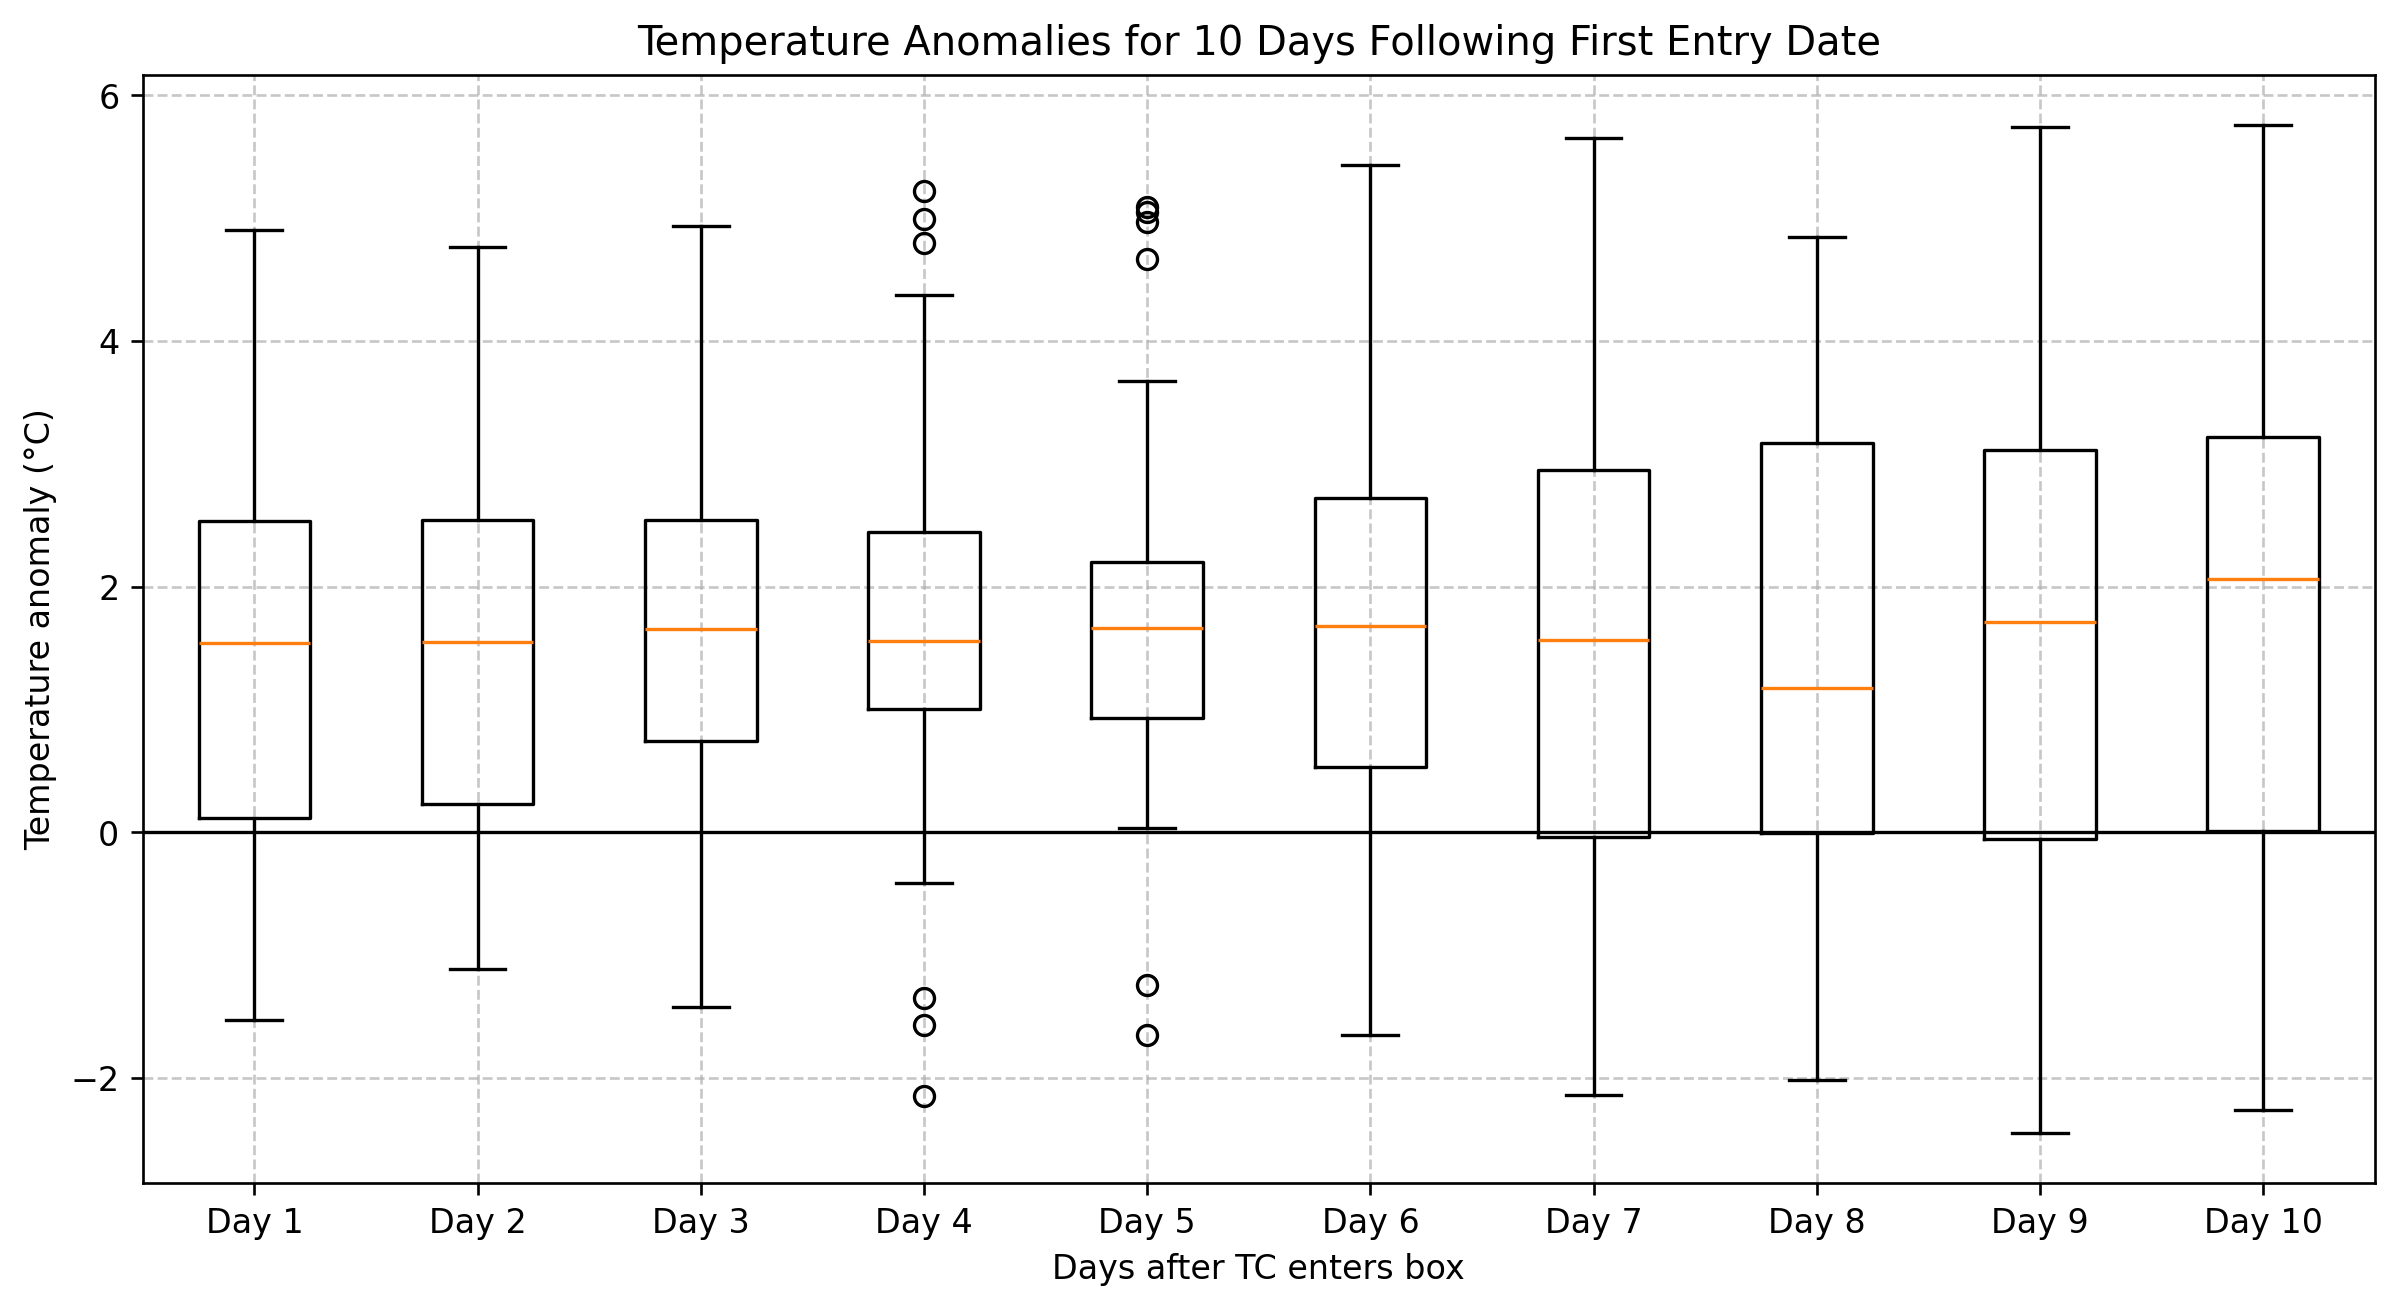

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array for easier indexing
anomaly_array = np.array(anomaly_matrix)  # shape (24, 10)

# Filter out NaNs for each day
data_to_plot = [anomaly_array[:, i][~np.isnan(anomaly_array[:, i])] for i in range(anomaly_array.shape[1])]

fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(data_to_plot, positions=range(1, len(data_to_plot) + 1))

ax.set_xlabel("Days after TC enters box")
ax.set_ylabel("Temperature anomaly (°C)")
ax.set_title("Temperature Anomalies for 10 Days Following First Entry Date")

ax.set_xticks(range(1, len(data_to_plot) + 1))
ax.set_xticklabels([f"Day {i}" for i in range(1, len(data_to_plot) + 1)])

ax.axhline(0, color='black', linestyle='-', linewidth=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Extratropical Transition

In [9]:
ibtracs_atl.nature

<xarray.DataArray 'nature' (storm: 146, date_time: 177)> Size: 207kB
array([[b'SS', b'SS', b'SS', ..., nan, nan, nan],
       [b'TS', b'TS', b'TS', ..., nan, nan, nan],
       [b'DS', b'DS', b'DS', ..., nan, nan, nan],
       ...,
       [b'ET', b'ET', b'ET', ..., nan, nan, nan],
       [b'DS', b'DS', b'DS', ..., nan, nan, nan],
       [b'DS', b'DS', b'DS', ..., nan, nan, nan]], dtype=object)
Coordinates:
    time     (storm, date_time) datetime64[ns] 207kB 2018-05-25T12:00:00.0000...
    lat      (storm, date_time) float32 103kB 18.8 18.7 18.7 ... nan nan nan
    lon      (storm, date_time) float32 103kB -87.1 -86.8 -86.5 ... nan nan nan
Dimensions without coordinates: storm, date_time
Attributes:
    long_name:              Nature of the cyclone
    Note:                   NR=Not_Reported DS=Disturbance TS=Tropical_System...
    coverage_content_type:  thematicClassification

In [18]:
et_mask = ibtracs_atl['nature'] == b'ET'

# Apply the mask to select only ET entries
et_only = ibtracs_atl.where(et_mask, drop=True)

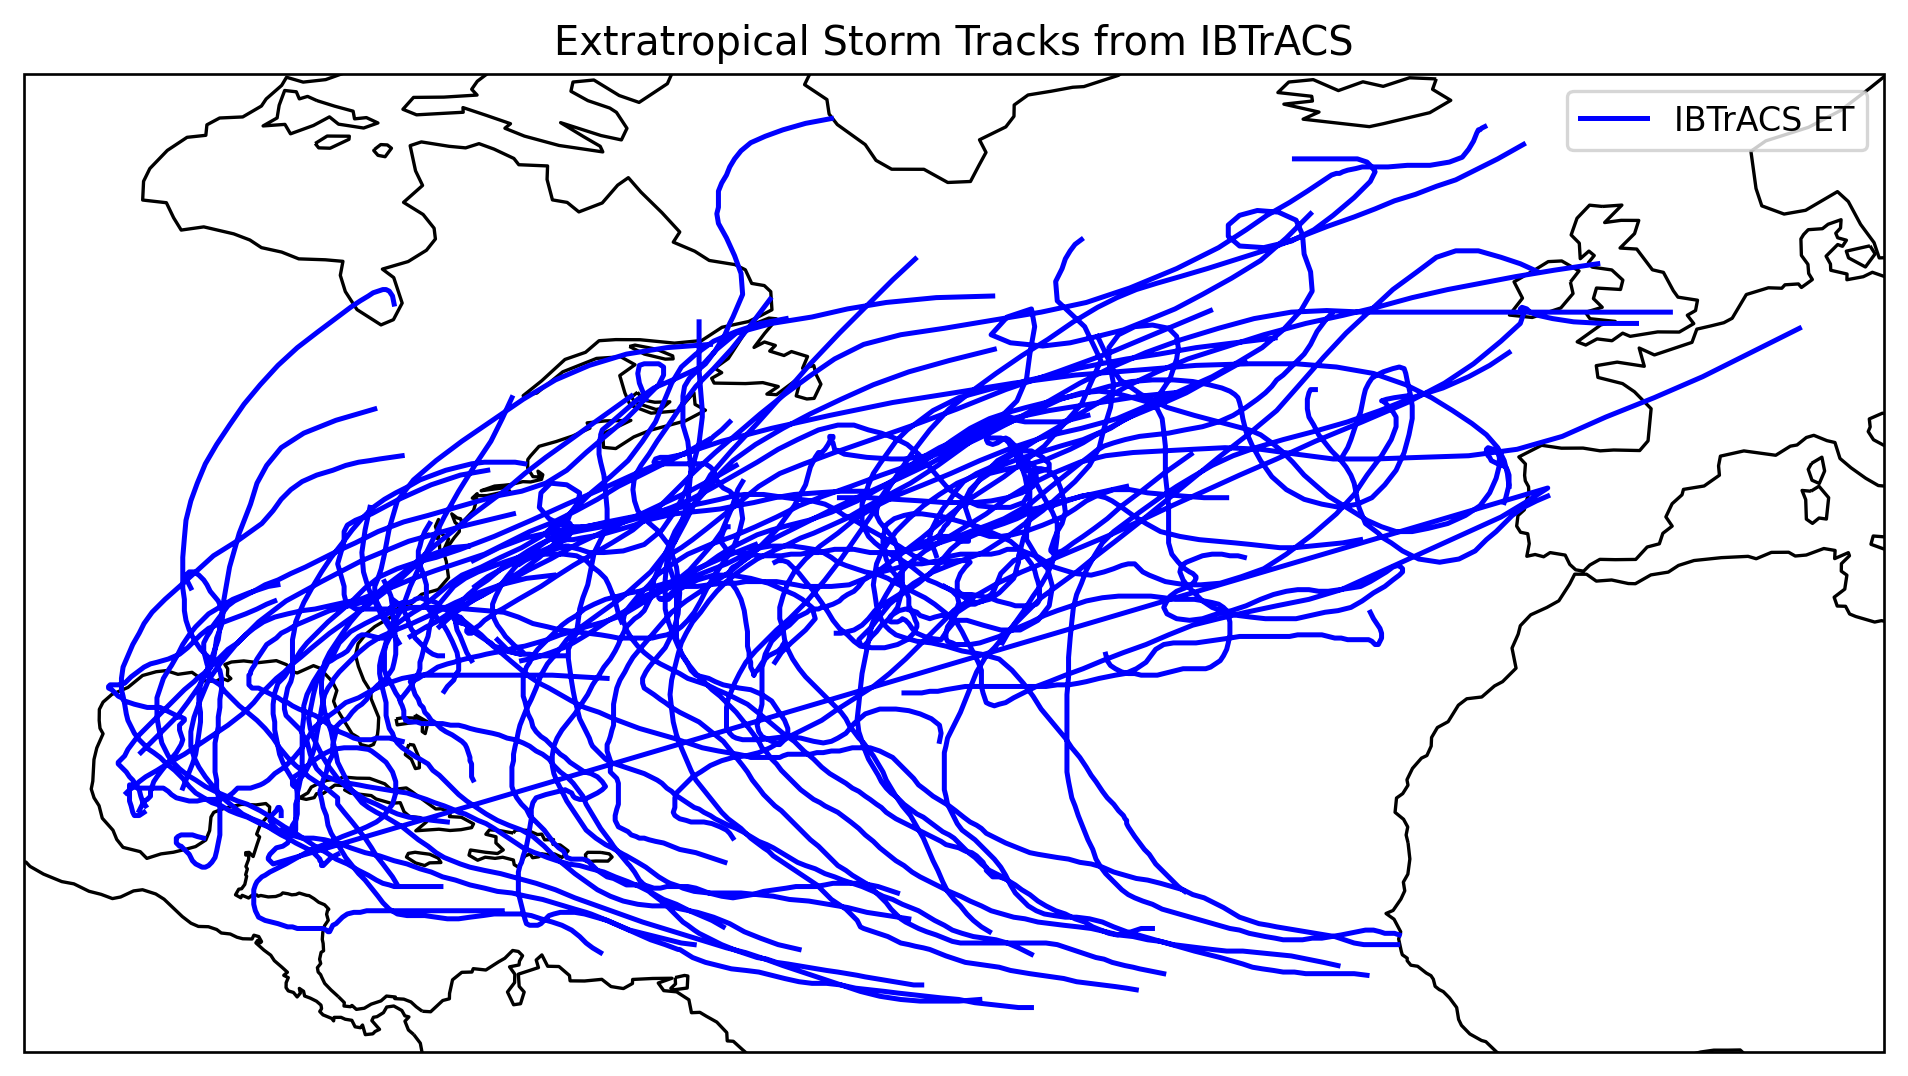

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Setup projection (PlateCarree works for lat/lon)
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})

# Add coastlines and optional features
ax.coastlines()

# Plot ET storm track points
ax.plot(et_only.lon.values.flat,
        et_only.lat.values.flat,
        color='b',
        linestyle='-',
        label='IBTrACS ET')

# Add legend and title
ax.legend()
ax.set_title("Extratropical Storm Tracks from IBTrACS")

# Optional: Set lat/lon extent
# ax.set_extent([-100, 20, 0, 60])  # Example for Atlantic

plt.show()


In [32]:
et_only.isel(storm=0).nature

<xarray.DataArray 'nature' (date_time: 173)> Size: 1kB
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, b'ET', b'ET', b'ET', b'ET',
       b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET',
       b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET',
       b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET',
       b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', b'ET', nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=object)
Coordinates:
    time     (date_time) datetime64[ns] 1kB 2018-07-05T06:00:00.000039936 ......
    lat      (date_time) float32 692B 30.7 30.7 30.7 30.7 ... nan nan nan nan
    lon      (date_time) float32 692B -68.5 -69.1 -69.7 -70.2 ... nan nan nan
Dimensions without coordinates: date_time
Attributes:
    long_name:              Nature of the cyclone
    Note:                   NR=Not_Reported DS=Disturbance TS=Tropical_System...
    coverage_content_type:  thematicClassification

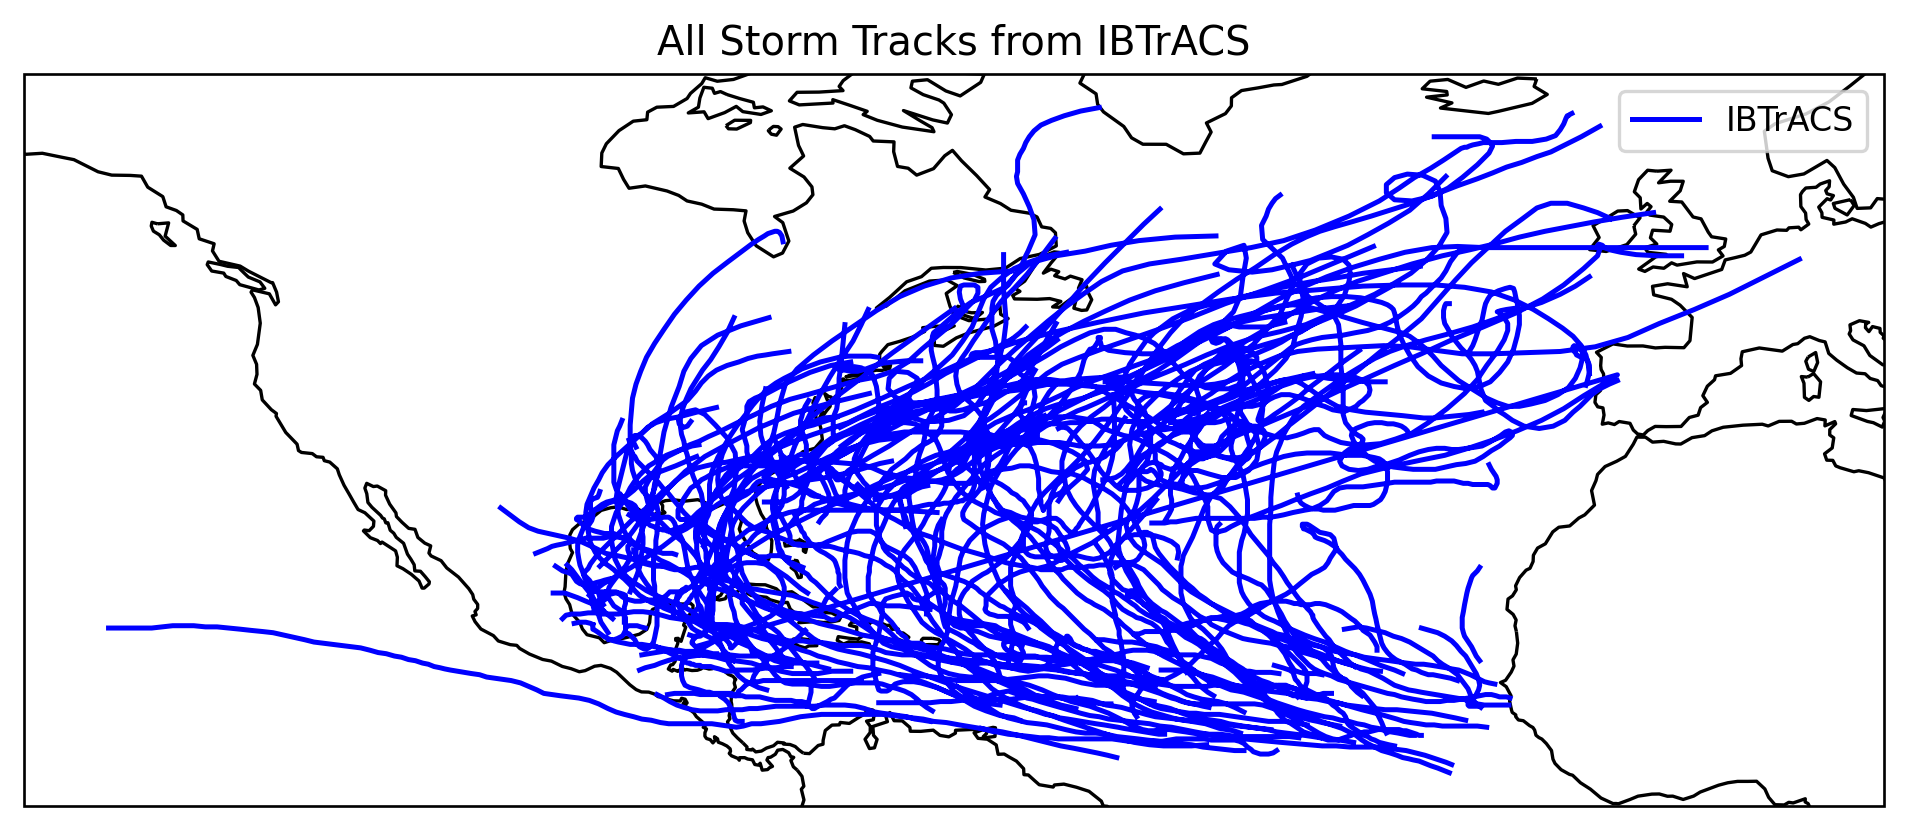

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Setup projection (PlateCarree works for lat/lon)
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})

# Add coastlines and optional features
ax.coastlines()

# Plot ET storm track points
ax.plot(ibtracs_atl.lon.values.flat,
        ibtracs_atl.lat.values.flat,
        color='b',
        linestyle='-',
        label='IBTrACS')

# Add legend and title
ax.legend()
ax.set_title("All Storm Tracks from IBTrACS")

# Optional: Set lat/lon extent
# ax.set_extent([-100, 20, 0, 60])  # Example for Atlantic

plt.show()
